In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import Operator
import numpy as np
import sympy as sp # just for displaying proper labels

We start by implementing the gate that copies |x> and pastes on the zero-value state |z>. In another words, it maps |x>|0> to |x>|x>, although we haven't studied what it does for other inputs. It consists of $d$ Control-Not (CX) gates for input dimension $d$. We only use it for initializing the answer state of out-of-place addition.

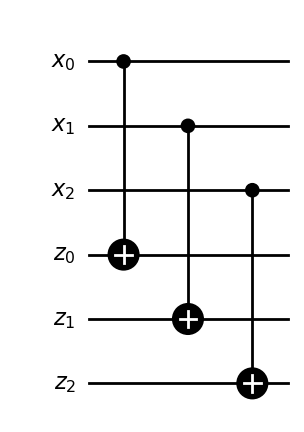

In [2]:
def stateCopy(d): # |x>|0> => |x>|x>
    x = QuantumRegister(size=d, name="x")
    z = QuantumRegister(size=d, name="z")
    copyCirc = QuantumCircuit(x, z, name="copy")
    
    for i in range(d):
        copyCirc.cx(x[i], z[i])

    return copyCirc
testCirc = stateCopy(3)
testCirc.draw(output="mpl", style="bw")

Next, we decompse the Control-Phase (CP) gate by $2$ CX and $3$ Phase gate, where the latter can be replaced by a U gate. It is used for qft, iqft and addition in phase space.

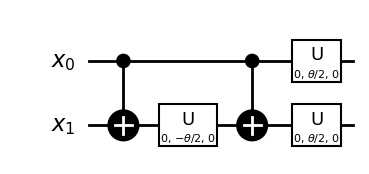

In [3]:
t = Parameter(r"$\theta$")
x = QuantumRegister(size=2, name="x")
cpDecompose = QuantumCircuit(x, name="cp")

cpDecompose.cx(x[0], x[1])
cpDecompose.u(0, -t/2, 0, x[1]) # p(theta) == u(0,theta,0)
cpDecompose.cx(x[0], x[1])
cpDecompose.u(0, t/2, 0, x[1])
cpDecompose.u(0, t/2, 0, x[0])

cpDecompose.draw(output="mpl", style="bw")

With CP in hand, we can further decompose the CCP gate into $2$ CX gates and $3$ CP gates. It is used by multiplication in phase space.

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.-0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+1.j]]


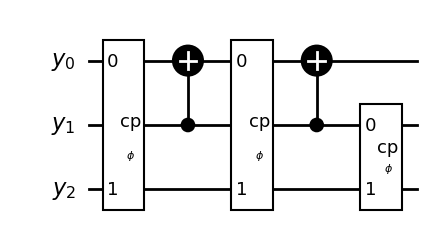

In [4]:
p = Parameter(r"$\phi$")
y = QuantumRegister(size=3, name="y")
ccpDecompose = QuantumCircuit(y, name="ccp")

cpGate_p = cpDecompose.assign_parameters({t:p/2}).to_gate(label=r'cp')
cpGate_n = cpDecompose.assign_parameters({t:-p/2}).to_gate(label=r'cp')


ccpDecompose.compose(cpGate_p, qubits=[0, 2], inplace=True)
ccpDecompose.cx(y[1], y[0])
ccpDecompose.compose(cpGate_n, qubits=[0, 2], inplace=True)
ccpDecompose.cx(y[1], y[0])
ccpDecompose.compose(cpGate_p, qubits=[1, 2], inplace=True)

testCirc = ccpDecompose.assign_parameters({p:np.pi/2})
print(np.round(Operator(testCirc).data, 3))

ccpDecompose.draw(output="mpl", style="bw")

Before qft, we also need a swap gate consisting of $3$ CX gates.

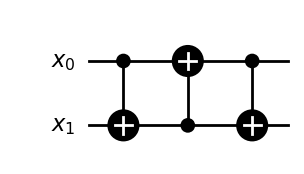

In [5]:
swapDecompose = QuantumCircuit(x, name='swap')

swapDecompose.cx(x[0], x[1])
swapDecompose.cx(x[1], x[0])
swapDecompose.cx(x[0], x[1])

swapDecompose.draw(output="mpl", style="bw")

Now we modify the qft gate given by Problem Session II by replacing Swap, Hadamard and CP with our own construction, where floor($n/2$) Swap, $n$ Hadamard (or U) and $1+2+\cdots+n-1=n(n-1)/2$ CP are involved.

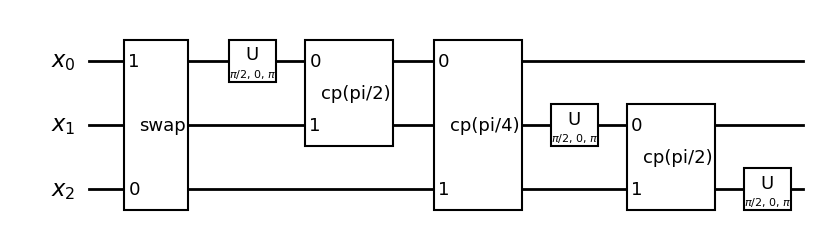

In [6]:
def qftDecompose(n): # |x1x2...xn> => |F(x1)F(x2)...F(xn)>
    x = QuantumRegister(size=n, name="x")
    qftCirc = QuantumCircuit(x, name='qft')

    for q, p in zip(x[:n >> 1], reversed(x[n >> 1:])):
        swapGate = swapDecompose.to_gate()
        qftCirc.compose(swapGate, qubits=[p,q], inplace=True)

    for i, q in enumerate(x, start=1):
        qftCirc.u(np.pi/2, 0, np.pi, q) # h == u(pi/2,0,pi)
        for j, p in enumerate(x[i:], start=1):
            cpGate = cpDecompose.assign_parameters({t:np.pi/(1<<j)}).to_gate(label='cp({})'.format(sp.pi/(1<<j)))
            qftCirc.compose(cpGate, qubits=[q, p], inplace=True)

    return qftCirc

testCirc = qftDecompose(3)
testCirc.draw(output="mpl", style="bw")

iqft is much simpler, although we cannot simply do qft.inverse() because the angles are negated in this way.

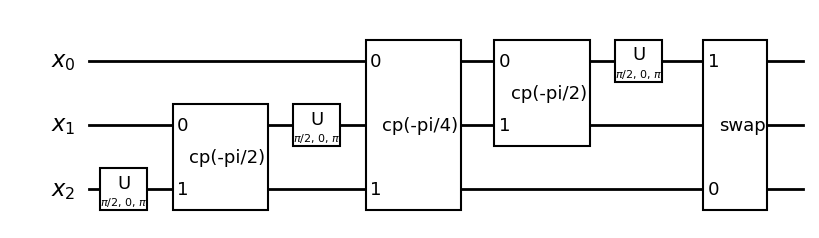

In [7]:
def iqftDecompose(n): # |F(a1)F(a2)...F(an)> => |a1a2...an>
    x = QuantumRegister(size=n, name="x")
    iqftCirc = QuantumCircuit(x, name='iqft')

    for i, q in enumerate(reversed(x), start=1):
        for j, p in enumerate(reversed(x[n + 1 - i:]), start=1):
            cpGate = cpDecompose.assign_parameters({t:-np.pi/(1<<(i-j))}).to_gate(label='cp({})'.format(-sp.pi/(1<<(i-j))))
            iqftCirc.compose(cpGate, qubits=[q, p], inplace=True)
        iqftCirc.u(np.pi/2, 0, np.pi, q)

    for q, p in zip(x[:n >> 1], reversed(x[n >> 1:])):
        swapGate = swapDecompose.to_gate()
        iqftCirc.compose(swapGate, qubits=[p,q], inplace=True)

    return iqftCirc

testCirc = iqftDecompose(3)
testCirc.draw(output="mpl", style="bw")

Here comes the adder given by [Draper](https://arxiv.org/abs/quant-ph/0008033 'Addition on a Quantum Computer'), the parallelized version, including $1$ copy, $1$ qft, $1+2+\cdots+n=n(n+1)/2$ CP, and $1$ iqft.

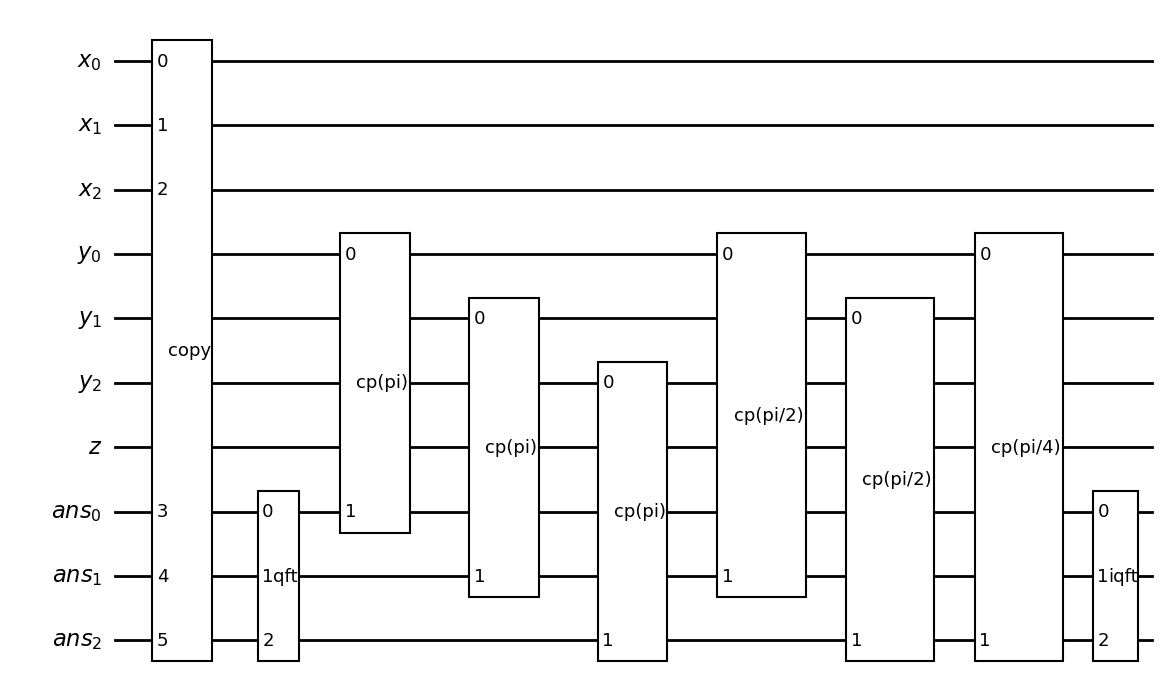

In [8]:
def adder(d):
    x = QuantumRegister(size=d, name="x")
    y = QuantumRegister(size=d, name="y")
    z = QuantumRegister(size=1, name="z")
    ans = QuantumRegister(size=d, name="ans"); arange = range(2*d+1,3*d+1)
    circ = QuantumCircuit(x, y, z, ans, name='{}-digit adder'.format(d))

    copyGate = stateCopy(d).to_gate()
    circ.compose(copyGate, qubits=list(range(d))+list(arange), inplace=True)

    qftGate = qftDecompose(d).to_gate()
    circ.compose(qftGate, qubits=arange, inplace=True)

    for i in range(d): # index for rotation angle
        for j in range(i,d): # index for ans
            cpGate = cpDecompose.assign_parameters({t:2*np.pi/2**(i+1)}).to_gate(label='cp({})'.format(2*sp.pi/2**(i+1)))
            circ.compose(cpGate, qubits=[d+j-i, 2*d+1+j], inplace=True)
    
    iqftGate = iqftDecompose(d).to_gate()
    circ.compose(iqftGate, qubits=arange, inplace=True)

    return circ
testCirc = adder(3)
testCirc.draw(output="mpl", style="bw")

In order to get a multiplier, we take the idea from [Ruiz and Garcia](https://arxiv.org/abs/1411.5949 'Quantum arithmetic with the Quantum Fourier Transform'), that $x\cdot y$ is adding up $2^k\cdot y$ to a zero state for all nonzero $x_k$'s, where $2^k\cdot y$ is simply shifting $y$ to the left for $k$ digits and leave the right hand side blank indices to be all zero, in the case of$\mod 2^d$. The gates are $1$ qft, $O(d^3)$ CP and $1$ iqft.

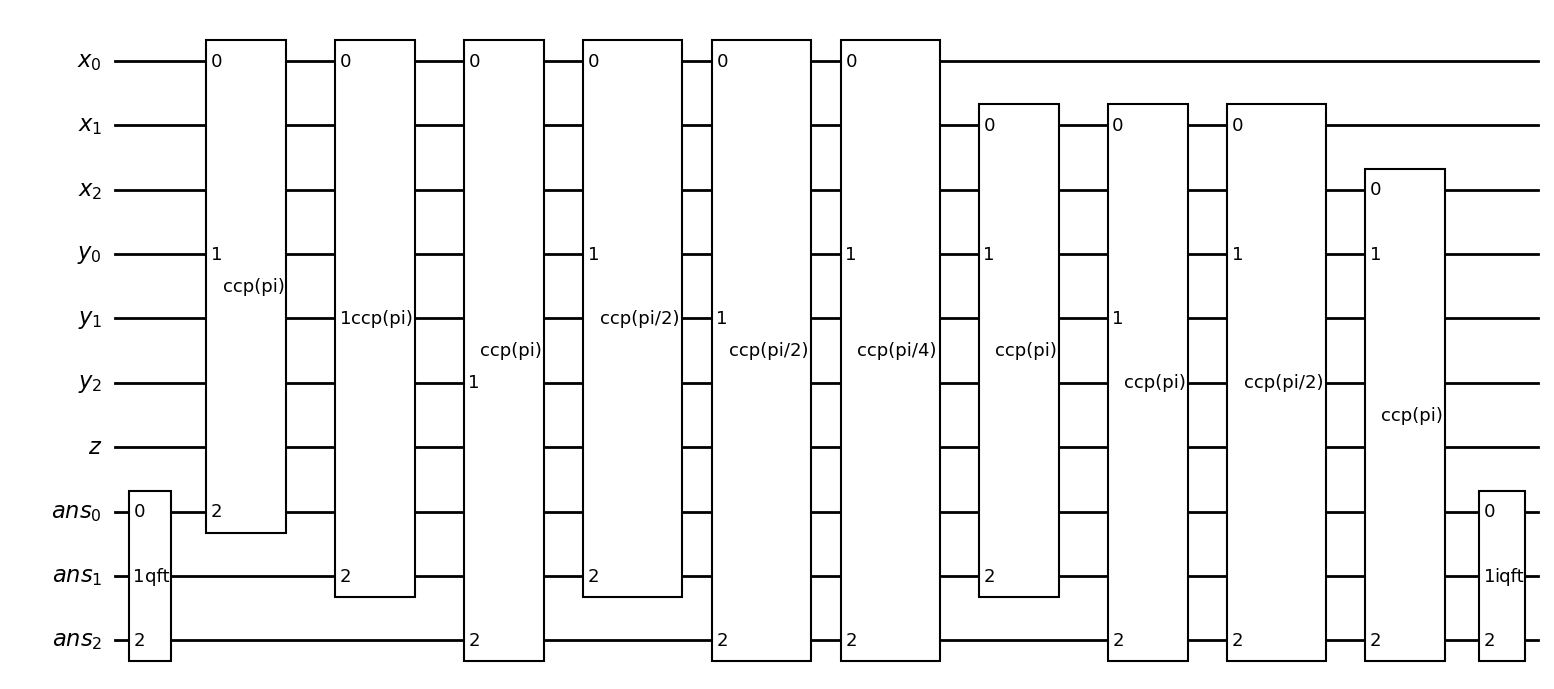

In [9]:
def multiplier(d): # ref: RGQFTMultiplier
    x = QuantumRegister(size=d, name="x")
    y = QuantumRegister(size=d, name="y")
    z = QuantumRegister(size=1, name="z")
    ans = QuantumRegister(size=d, name="ans"); arange = range(2*d+1,3*d+1)
    circ = QuantumCircuit(x, y, z, ans, name='{}-digit multiplier'.format(d))

    qftGate = qftDecompose(d).to_gate()
    circ.compose(qftGate, qubits=arange, inplace=True)

    for k in range(d): # index for x, adding 2^k|y_k> to ans when x_k==1
        for i in range(d): # index for rotation angle
            for j in range(i+k,d): # index for ans, where 2^k|y_k> is all-zero for indices 0 through k-1
                ccpGate = ccpDecompose.assign_parameters({p:2*np.pi/2**(i+1)}).to_gate(label='ccp({})'.format(2*sp.pi/2**(i+1)))
                circ.compose(ccpGate, qubits=[k, d+j-i-k, 2*d+1+j], inplace=True)

    iqftGate = iqftDecompose(d).to_gate()
    circ.compose(iqftGate, qubits=arange, inplace=True)

    return circ
testCirc = multiplier(3)
testCirc.draw(output="mpl", style="bw")

Finally, The combination of above two operations is simply replacing every CX gate by CCX (Toffoli) with an additional control given by $z$. Since every decomposition has to be changed, the final result is implemented in another notebook.